# Lab 3 - Dane Lidar - LAS

## Zadanie 1

Za pomocą poznanych bibliotek dokonaj interpolacji pliku LAS (`swidwie_dense_cloud_crop.las`), do rozdzielczości 10 cm. Zapisz plik w formacie GeoTIF w układzie współrzędnych UTM-33N (EPS:32633)

In [1]:
import whitebox
import os
import matplotlib.pyplot as plt
import imageio
from rasterio.plot import show
%matplotlib inline 
wbt = whitebox.WhiteboxTools()
data_dir = "C:\Dev\jad3\lab3"

### Interpolacja

Wybrano interpolację `lidar_nearest_neighbour_gridding`, która polega na metodzie najbliższych sąsiadów.

In [2]:
wbt.set_working_dir(data_dir)
wbt.verbose = False
las = "swidwie_dense_cloud_crop.las"
resolution = 0.1
# funkcje whiteboxtool https://rdrr.io/rforge/whitebox/man/lidar_nearest_neighbour_gridding.html
wbt.lidar_nearest_neighbour_gridding(las, "las_grid_10cm.tif", parameter = "elevation", returns = "all", resolution = resolution,
  radius = 2.5)

0

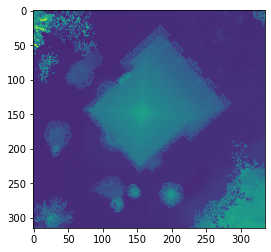

In [4]:
raster = imageio.imread(os.path.join(data_dir, 'las_grid_10cm.tif'))
plt.imshow(raster)
plt.show()

### Zapisanie w formacie GeoTif w zadanym układzie współrzędnych  

In [22]:
from osgeo import gdal
from osgeo import osr

gdal.AllRegister()

In [26]:
nmt = gdal.Open('C:\Dev\jad3\lab3\las_grid_10cm.tif')
srs = osr.SpatialReference()
srs.ImportFromEPSG(32633)
nmt.SetProjection(srs.ExportToWkt())

band = nmt.GetRasterBand(1)
arr = band.ReadAsArray()
[cols, rows] = arr.shape

driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create("C:\Dev\jad3\lab3\las_grid_10cm_EPSG-32633.tif", rows, cols, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(nmt.GetGeoTransform())
outdata.SetProjection(srs.ExportToWkt())
outdata.GetRasterBand(1).WriteArray(arr)
outdata.GetRasterBand(1).SetNoDataValue(-9999)
outdata.FlushCache()
nmt=None

## Zadanie 2

Pobierz plik LAX ze strony internetowej geoportal.gov.pl, obszaru metropolitarnego miasta Szczecin. Dokonaj wyboru punktów w klasach => ground, water, buildings, vegetation. Użyj do tego wybranej biblioteki PYTHON. Dane zwizualizuaj w postaci mapy za pomocą, np. matplotlib, folium lub innej wybranej biblioteki. Wyświetl legendę.

In [3]:
import whitebox
import matplotlib.pyplot as plt
import imageio
import laspy as lp
import pylas 
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## Konwersja do LAS

In [5]:
laz_filename = 'szczecin.laz'
las_filename = 'szczecin.las'
las = pylas.read(laz_filename)    
las = pylas.convert(las)    
las.write(las_filename)

## Wczytanie Lidar

In [7]:
wbt = whitebox.WhiteboxTools()
data_dir = "C:\\Dev\\jad3\\lab3"
wbt.set_working_dir(data_dir)
wbt.lidar_info(las_filename)
wbt.verbose = False
outFile = "szczecinClassified.las"

.\whitebox_tools.exe --run="LidarInfo" --wd="C:\Dev\jad3\lab3" --input='szczecin.las' --vlr --geokeys -v

************************
* Welcome to LidarInfo *
************************
Complete! Please see C:\Dev\jad3\lab3\szczecin_summary.html for output.


## Dokonaj wyboru punktów w klasach => ground, water, buildings, vegetation"

In [8]:
wbt.filter_lidar_classes(las_filename, outFile, exclude_cls = "0,1,7,8,10,11,12,13,14,15,16,17,18")
wbt.lidar_remove_outliers(outFile, outFile, radius = 1, elev_diff = 1, use_median = 1, classify = 1,)
gridFile = "szczecinClassified.tif"

## Konwersja do rastra

In [9]:
wbt.lidar_nearest_neighbour_gridding(outFile, gridFile, parameter = "elevation", returns = "all", resolution = 0.1, radius = 0.1)

0

## Wizualizacja

No handles with labels found to put in legend.


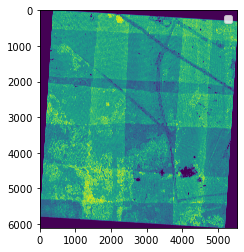

In [10]:
raster = imageio.imread(os.path.join(data_dir, gridFile))
plt.figure()
plt.imshow(raster)
plt.legend()
plt.show()

## Zadanie 3

Na podstawie rastra z zadania 1 dokonaj przecięcia linią zdefiniowaną w postaci WKT:  

```
LineString (192958.61605744 641545.91446278, 192990.84074139 641570.17557541)
```

Pamiętaj o konwersji linii lub pliku rastrowego do układu współrzędnych PL1992 (epsg:2180).
Pobierz wartości wszystkich pikseli znajdujących się wzdłuż przecięcia linią do pliku csv. Stworzony w ten sposób przekrój terenu zwizualizuj w za pomocą matplotlib.